In [1]:
import os 
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import pygmt
from scipy import stats
from scipy.stats import wilcoxon
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from xarray import DataArray
from scipy.ndimage import gaussian_filter
from numpy import deg2rad, sin, cos, meshgrid, gradient

In [2]:
def regridding1(carbdata):
    ds_in = xr.DataArray(
        dims=["latitude", "longitude"],
        coords={"latitude": np.arange(-90,90.05,0.05), "longitude": np.arange(-180,180.05,0.05)},
    )
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.1, -90.0, 90.0, 0.1)
    regrid = xe.Regridder(ds_in, ds_out, 'nearest_s2d', periodic=True, weights='../paleo_reef/data/nearest_s2d_gridder_res1.nc')
    return regrid(carbdata)

def regridding2(ds):
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.25, -90.0, 90.0, 0.25)
    regrid = xe.Regridder(ds, ds_out, 'nearest_s2d', periodic=True, weights='../paleo_reef/data/nearest_s2d_gridder_res2.nc')
    return regrid(ds)

def getData(timeclim, CO2curve='smooth'):
    abiotic = xr.open_dataset('../paleo_reef/env_var/enviVar'+str(timeclim)+'Ma_res1_'+CO2curve+'.nc')
    continent = abiotic.flood.fillna(10)
    continent = continent.where(continent>4)
    abiotic['elevation'] = abiotic.bathy.copy()
    shelf = xr.open_dataset('../paleo_reef/data/shelfs/'+str(timeclim)+'Ma.nc')
    shelf2 = regridding1(shelf)
    shelf.close()
    abiotic['shelf'] = (('latitude', 'longitude'), shelf2.flood.values)
    if CO2curve=='smooth':
        ensemble = xr.open_dataset('../paleoReef/photozoan.res2.smooth/proj_'+str(timeclim)+'Ma/proj_'+str(timeclim)+'Ma_photozoan.res2_ensemble.tif')    
    else:
        ensemble = xr.open_dataset('../paleoReef/photozoan.res2/proj_'+str(timeclim)+'Ma/proj_'+str(timeclim)+'Ma_photozoan.res2_ensemble.tif')
    return abiotic, ensemble, continent

def earth_radius(lat):
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    return r

def area_grid(lat, lon):
    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    area = dy * dx
    xda = DataArray(
        area,
        dims=["latitude", "longitude"],
        coords={"latitude": lat, "longitude": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

In [3]:
bins = np.linspace(0, 1000, 21)

occ_df = pd.read_csv('data/occurrences.csv')
cleanDF = pd.read_csv('data/cleanFossilRecords.csv')
curve = 'foster'
range_deg = 1.

In [4]:
if os.path.isfile('data/performance_smooth.csv'):
    perf_df_smooth = pd.read_csv('data/performance_smooth.csv')
    perf_df_foster = pd.read_csv('data/performance_foster.csv')
else:
    curve = 'smooth'
    vmean = []
    vstd = []
    vperc = []

    for t in range(len(occ_df)):
        timeclim = occ_df['simt'].iloc[t]
        abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
        flooddata = regridding2(abiotic)
        da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

        dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

        dataName = ['Mean', 'Coefficient of variation', 'Median', 
                    'Committee averaging score', 'Weighted mean', 
                    'Confidence interval (lower)', 'Confidence interval (upper)']
        nda = xr.DataArray(
                            ensemble.isel(band=4).band_data.values,
                            dims=["latitude", "longitude"],
                            coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                        )
        dataEM = nda.to_dataset(name=dataType[4])
        tmp = nda.fillna(0).values
        dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
        dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
        dataEMFlood = dataEM.where(dataEM.flood==1)
        latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
        lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
        time2 = occ_df['scot'].iloc[t]
        position = np.zeros((len(latsco),2))
        position[:,0] = latsco
        position[:,1] = lonsco
        vvv = []
        for k in range(len(latsco)):
            val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
              longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
            vvv.append(val)
        vvv = np.asarray(vvv)
        nonans = ~np.isnan(vvv)
        vmean.append(vvv[nonans].mean())
        vstd.append(vvv[nonans].std())
        vperc.append(len(vvv[nonans])*100/len(vvv))

    if curve == 'foster':

        dataf = {
            "fperc": vperc,
            "fstd": vstd,
            "fmean": vmean,
        }
        perf_df_foster = pd.DataFrame(dataf)
        perf_df_foster['simt'] = occ_df['simt']
        perf_df_foster.to_csv('data/performance_foster.csv',index=False)
    else:
        datas = {
            "sperc": vperc,
            "sstd": vstd,
            "smean": vmean,
        }
        perf_df_smooth = pd.DataFrame(datas)
        perf_df_smooth['simt'] = occ_df['simt']
        perf_df_smooth.to_csv('data/performance_smooth.csv',index=False)

In [5]:
perf_df_foster

,fperc,fstd,fmean,simt
0,90.322581,340.743758,221.357446,4
1,100.000000,329.331316,345.454888,10
2,96.153846,354.496155,369.631161,14
3,89.247312,311.185356,490.809990,19
4,57.142857,322.804502,512.740453,25
5,88.888889,287.294699,315.275289,31
6,100.000000,84.842991,189.799160,35
7,75.000000,179.022911,339.257019,39
8,91.666667,127.835753,303.495815,44
9,66.666667,207.895021,501.529118,52


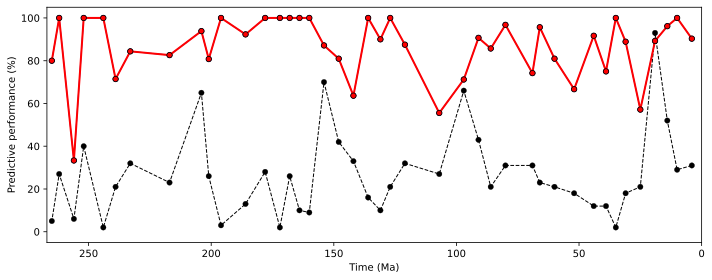

In [6]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='Predictive performance (%)',
       xlabel='Time (Ma)')
plt.plot(occ_df['simt'], perf_df_foster['fperc'], color = 'r', lw='2', ls='-',zorder=2)
plt.scatter(occ_df['simt'], perf_df_foster['fperc'], s=30,
            marker='o',facecolor='red',lw=0.8,
            edgecolor='black',zorder=2)

plt.plot(occ_df['simt'], perf_df_smooth['sperc'], color = 'b', lw='1', ls='-',zorder=1)
plt.scatter(occ_df['simt'], perf_df_smooth['sperc'], s=30,
            marker='o',facecolor='b',lw=0.3,
            edgecolor='black',zorder=1)

plt.plot(occ_df['simt'], occ_df['count'], color = 'k', lw='1', ls='--',zorder=1)
plt.scatter(occ_df['simt'], occ_df['count'], s=30,
            marker='o',facecolor='black',lw=0.3,
            edgecolor='black',zorder=1)

plt.ylim(-5, 105)
plt.xlim(0, 267)
ax.invert_xaxis()
f.tight_layout()
# f.savefig('predict_performance.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

In [11]:
perf_df_foster['fperc'].mean(),perf_df_foster['fperc'].quantile(0.2),perf_df_foster['fperc'].quantile(0.5), perf_df_foster['fperc'].quantile(0.7),perf_df_foster['fperc'].std()

(86.51764358957804,
 76.0,
 90.16129032258064,
 99.03225806451613,
 15.051928030826481)

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


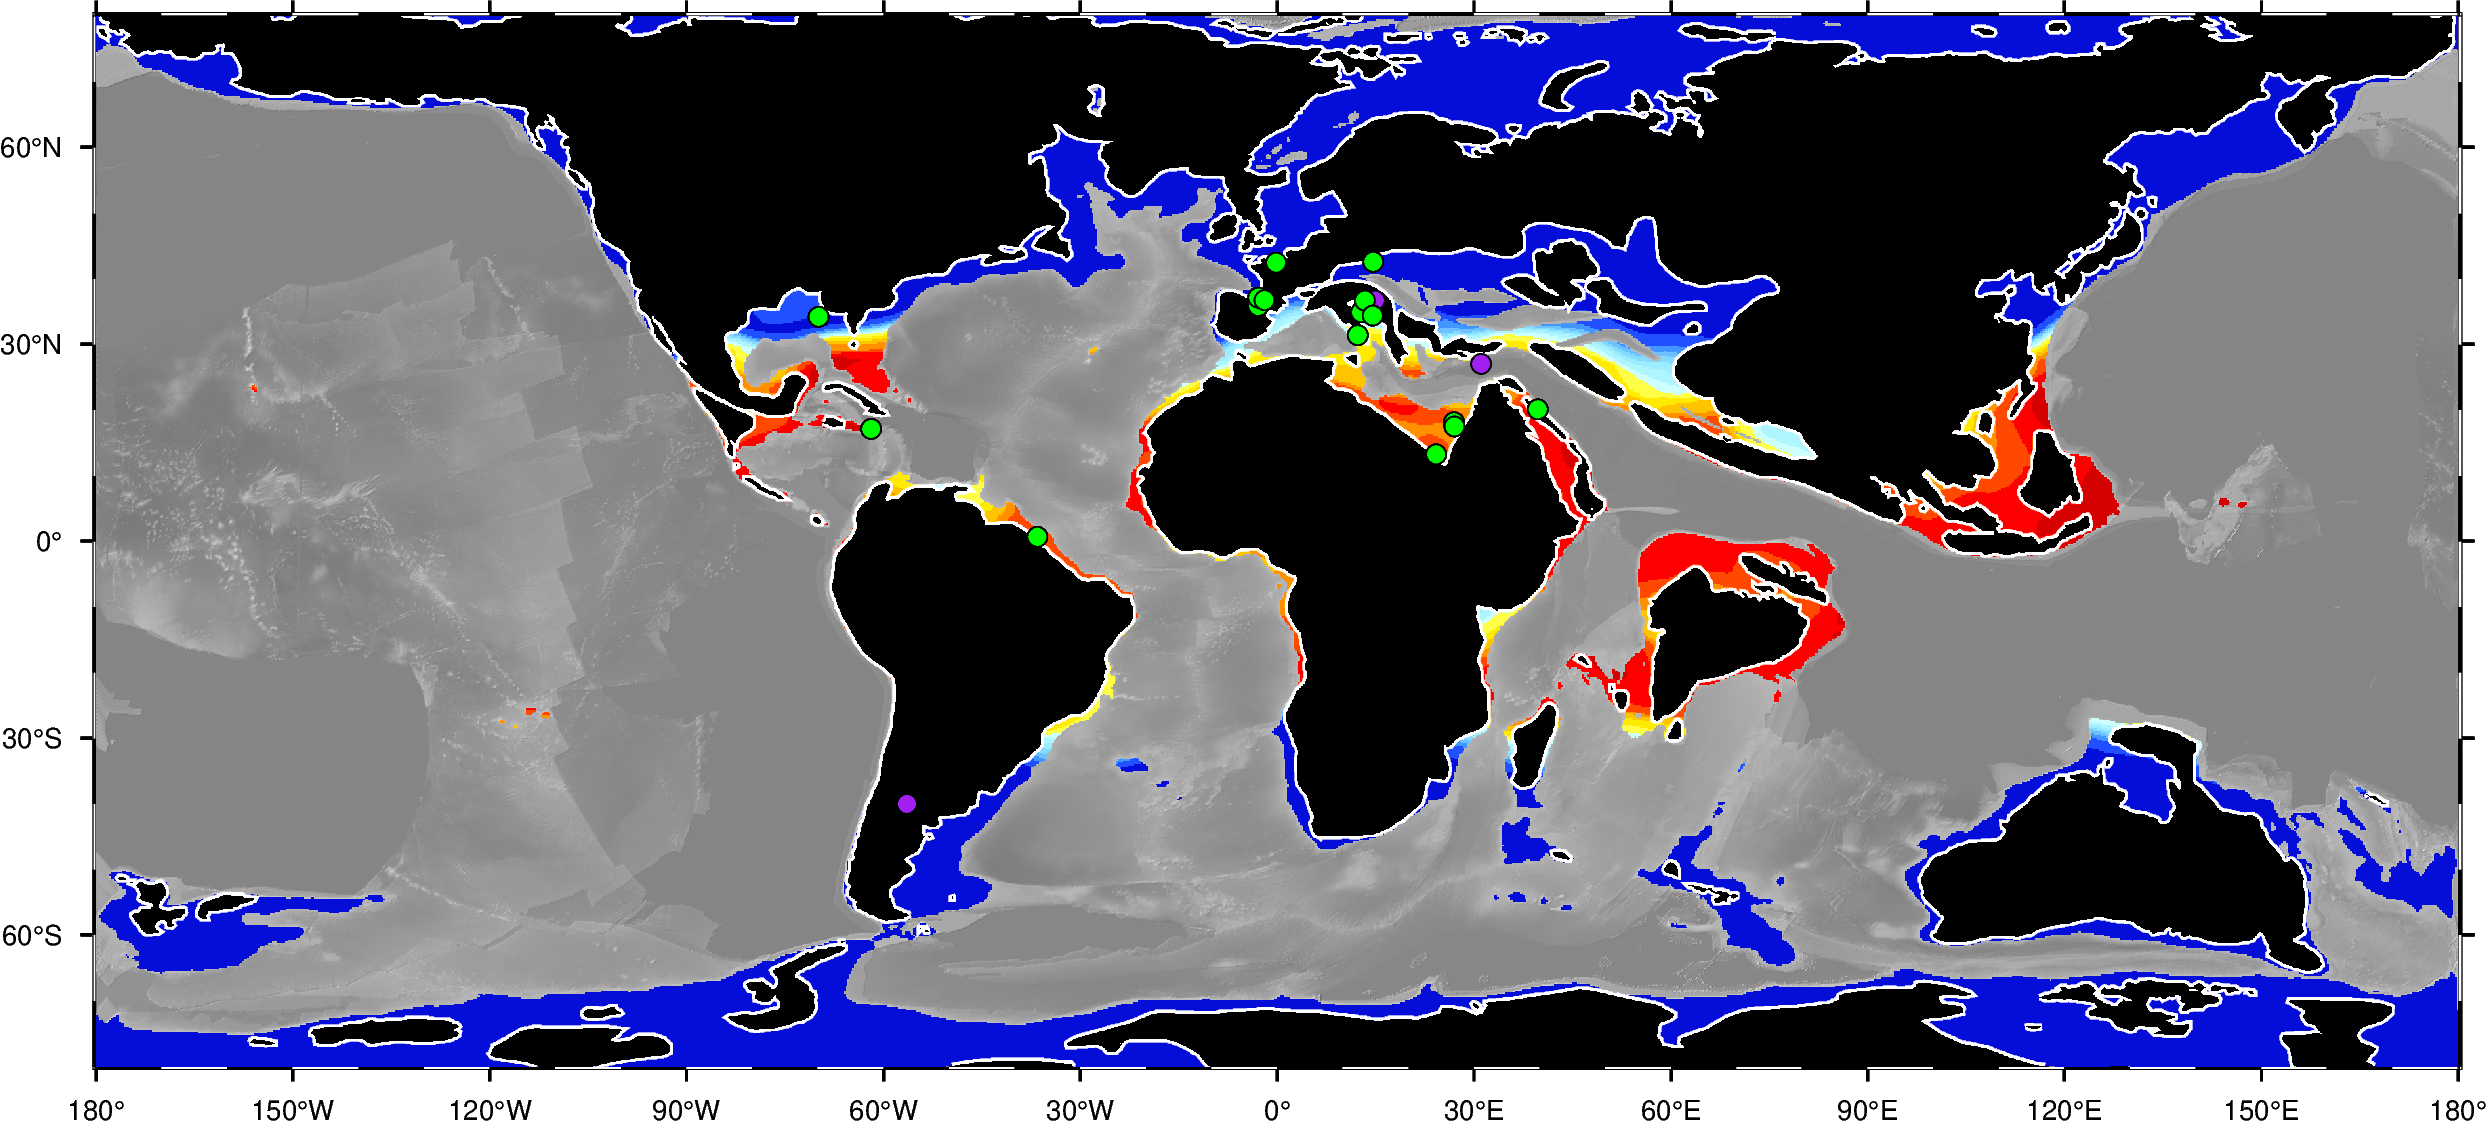

In [6]:
t = 10
timeclim = occ_df['simt'].iloc[t]
abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
flooddata = regridding2(abiotic)
da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

dataName = ['Mean', 'Coefficient of variation', 'Median', 
            'Committee averaging score', 'Weighted mean', 
            'Confidence interval (lower)', 'Confidence interval (upper)']
nda = xr.DataArray(
                    ensemble.isel(band=4).band_data.values,
                    dims=["latitude", "longitude"],
                    coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                )
dataEM = nda.to_dataset(name=dataType[4])
tmp = nda.fillna(0).values
dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
dataEMFlood = dataEM.where(dataEM.flood==1)
latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
time2 = occ_df['scot'].iloc[t]
position = np.zeros((len(latsco),2))
position[:,0] = latsco
position[:,1] = lonsco
vvv = []
for k in range(len(latsco)):
    val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
      longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
    vvv.append(val)
vvv = np.asarray(vvv)
nonans = ~np.isnan(vvv)

region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
    fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
    fig.grdimage(dataEMFlood.wmean.where(dataEMFlood.wmean), shading=False, 
                 nan_transparent=True, frame=False) 
    
    fig.grdcontour(interval=1,grid=abiotic.shelf,limit=[1.9, 2],pen="0.9p,white")
    pygmt.makecpt(cmap="black", series=[8, 10])
    fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    fig.plot(x=lonsco, y=latsco, style="c0.1/0.15c", color="purple", pen="0.2p,black")
    fig.plot(x=lonsco[nonans], y=latsco[nonans], style="c0.1/0.15c", color="green", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


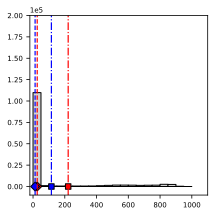

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


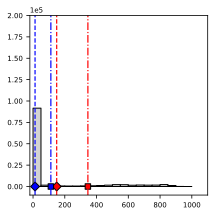

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


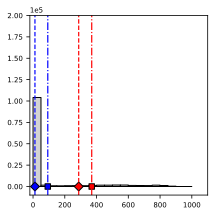

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


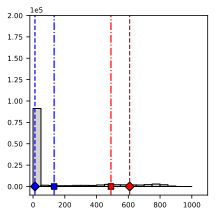

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


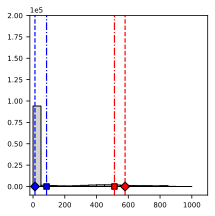

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


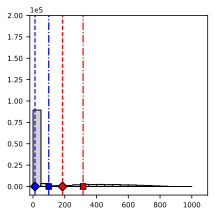

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


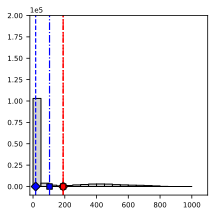

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


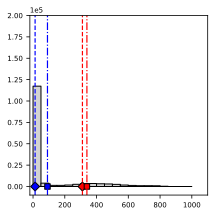

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


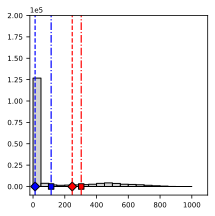

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


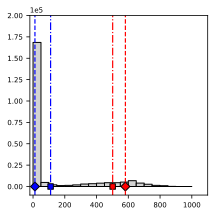

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


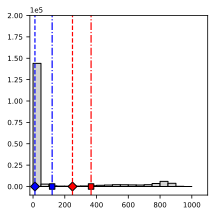

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


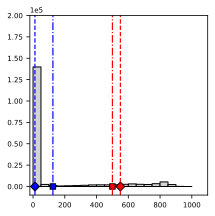

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


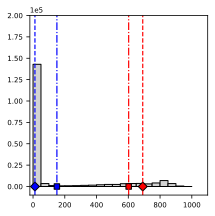

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


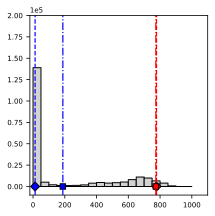

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


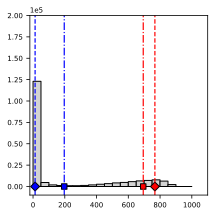

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


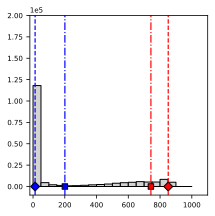

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


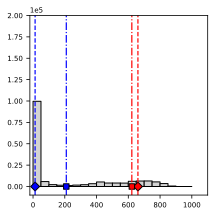

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


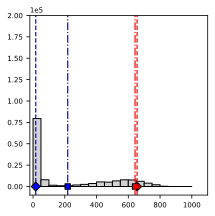

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


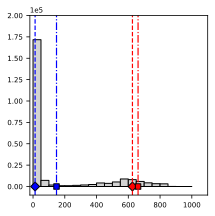

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


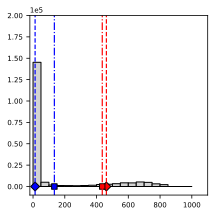

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


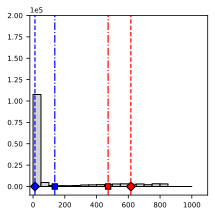

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


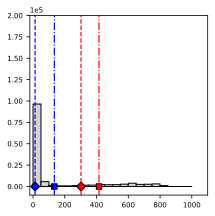

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


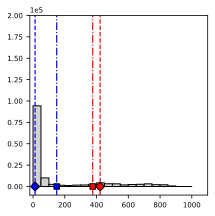

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


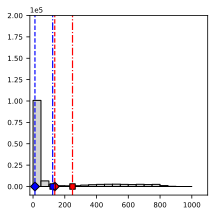

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


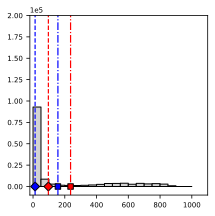

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


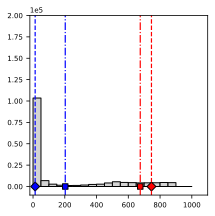

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


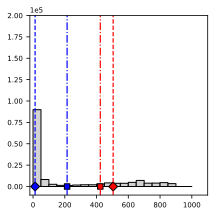

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


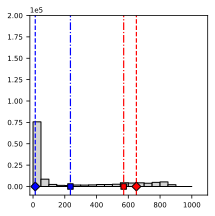

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


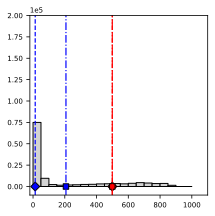

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


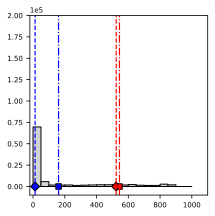

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


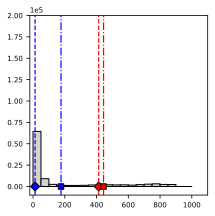

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


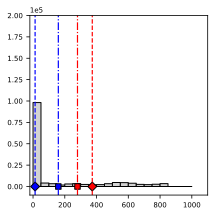

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


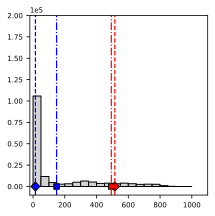

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


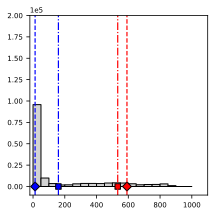

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


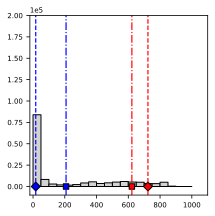

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


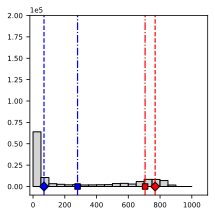

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


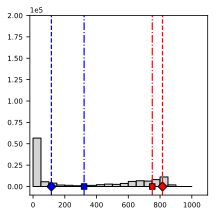

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


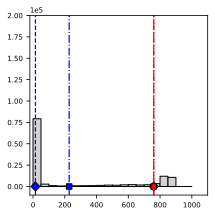

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


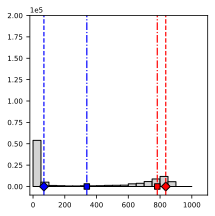

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


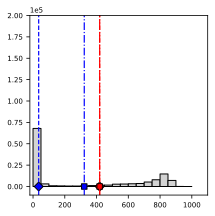

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


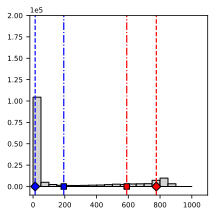

/Users/galois/conda/anaconda3/envs/gospl-global/lib/python3.9/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


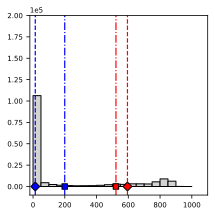

In [7]:
def plotPerformance(step):

    timeclim = occ_df['simt'].iloc[step]
    time2 = occ_df['scot'].iloc[step]
    abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
    flooddata = regridding2(abiotic)
    da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

    dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

    dataName = ['Mean', 'Coefficient of variation', 'Median', 
                'Committee averaging score', 'Weighted mean', 
                'Confidence interval (lower)', 'Confidence interval (upper)']
    nda = xr.DataArray(
                        ensemble.isel(band=4).band_data.values,
                        dims=["latitude", "longitude"],
                        coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                    )
    dataEM = nda.to_dataset(name=dataType[4])
    tmp = nda.fillna(0).values
    dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
    dataEMFlood = dataEM.where(dataEM.flood==1)
    latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
    lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
    position = np.zeros((len(latsco),2))
    position[:,0] = latsco
    position[:,1] = lonsco
    vvv = []
    for k in range(len(latsco)):
        val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
          longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
        vvv.append(val)
    vvv = np.asarray(vvv)
    nonans = ~np.isnan(vvv)

    vals = dataEMFlood.wmean.values.flatten().copy()
    randpts = vals[~np.isnan(vals)]
    randpts = np.random.choice(randpts, size=1000)

    med_rand = np.median(randpts)
    mean_rand = np.mean(randpts)
    res = mannwhitneyu(vvv[nonans],randpts,alternative='greater')

    font = {'family': 'DejaVu Sans',
            'color':  'k',
            'weight': 'normal',
            'size': 8
            }

    plt.rcParams.update({'font.size': 7})
    
    f, ax = plt.subplots(figsize=(3, 3))

    # valhist = (da_area/da_area.max()).data*ensembleReef.wmean
    dataEMFlood.wmean.plot.hist(bins=np.linspace(0, 1000, 21),color='lightgray',
                                edgecolor='black', linewidth=1)

    ax.set(xlabel='',#'Habitat suitability',
           ylabel='')#'Frequency')
    plt.ylim(-1e4, 2e5)
    plt.xlim(-20, 1100)
    plt.axvline(x = np.median(vvv[nonans]), color = 'r', lw='1.2', ls='--')
    plt.scatter(np.median(vvv[nonans]),0,s=40,marker='D',facecolor='red',edgecolor='black')
    plt.axvline(x = med_rand, color = 'b', lw='1.2', ls='--')
    plt.scatter(med_rand,0,s=40,marker='D',facecolor='b',edgecolor='black')
    
    
    plt.axvline(x = np.mean(vvv[nonans]), color = 'r', lw='1.2', ls='-.')
    plt.scatter(np.mean(vvv[nonans]),0,s=30,marker='s',facecolor='red',edgecolor='black')
    plt.axvline(x = mean_rand, color = 'b', lw='1.2', ls='-.')
    plt.scatter(mean_rand,0,s=30,marker='s',facecolor='b',edgecolor='black')

    if np.round(res.pvalue,3) < 0.001:
        pval = 0.001
    else:
        pval = np.round(res.pvalue,3)

#     plt.text(810, 1.875e5, r'W='+str(int(res.statistic)), fontdict=font)
#     plt.text(810, 1.75e5, r'P='+str(pval), fontdict=font)
#     plt.text(810, 1.635e5, r'n='+str(len(vvv)), fontdict=font)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    f.tight_layout()
    plt.savefig('figs/performance_'+str(timeclim)+'Ma.png', bbox_inches='tight', transparent=True, dpi=500)

    plt.show()
    plt.close()
    return


# plotPerformance(0)
for k in range(len(occ_df)):
    plotPerformance(k)

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
def getStats(step):
    timeclim = occ_df['simt'].iloc[step]
    time2 = occ_df['scot'].iloc[step]
    abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
    flooddata = regridding2(abiotic)
    da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

    dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

    dataName = ['Mean', 'Coefficient of variation', 'Median', 
                'Committee averaging score', 'Weighted mean', 
                'Confidence interval (lower)', 'Confidence interval (upper)']
    nda = xr.DataArray(
                        ensemble.isel(band=4).band_data.values,
                        dims=["latitude", "longitude"],
                        coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                    )
    dataEM = nda.to_dataset(name=dataType[4])
    tmp = nda.fillna(0).values
    dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
    dataEMFlood = dataEM.where(dataEM.flood==1)
    latsco = cleanDF[cleanDF['simt']==timeclim]['pal_lat_scotese'].values
    lonsco = cleanDF[cleanDF['simt']==timeclim]['pal_long_scotese'].values
    position = np.zeros((len(latsco),2))
    position[:,0] = latsco
    position[:,1] = lonsco
    vvv = []
    for k in range(len(latsco)):
        val = dataEMFlood.sel(latitude=slice(latsco[k]+range_deg,latsco[k]-range_deg),
          longitude=slice(lonsco[k]-range_deg,lonsco[k]+range_deg)).wmean.max().data+0.
        vvv.append(val)
    vvv = np.asarray(vvv)
    nonans = ~np.isnan(vvv)

    vals = dataEMFlood.wmean.values.flatten().copy()
    randpts = vals[~np.isnan(vals)]
    randpts = np.random.choice(randpts, size=1000)
    res = mannwhitneyu(vvv[nonans],randpts,alternative='greater') #,method='auto')
#     med_rand = np.median(randpts)
    
#     print(med_rand,np.median(vvv[nonans]))
    res1 = stats.ttest_ind(vvv[nonans], randpts)
    
    return res.statistic, res.pvalue, res1.statistic, res1.pvalue

# stat = []
# pval = []
# for k in range(len(occ_df)):
#     res1, res2 = getMannWhitney(k)
#     stat.append(res1)
#     pval.append(res2)
stat1 = []
pval1 = []
stat2 = []
pval2 = []
for k in range(len(occ_df)):
    st1, pv1, st2, pv2 = getStats(k)
    pval1.append(pv1)
    stat1.append(st1)
    stat2.append(st2)
    pval2.append(pv2)

In [9]:
data_stats = {
            "time": occ_df['simt'],
            "stat1": stat1,
            "stat2": stat2,
            "pval1": pval1,
            "pval2": pval2,
            "count": occ_df['count'],
        }
stat_df = pd.DataFrame(data_stats)

In [10]:
def cmptCentroid(latpos,latdata):
    
    cumd = np.cumsum(latdata)
    mid = np.sum(latdata)*0.5
    id2 = np.where(cumd>=mid)[0][0]
    p1 = 1.-(mid-cumd[id2-1])/(cumd[id2]-cumd[id2-1])
    return latpos[id2-1]*p1+latpos[id2]*(1.-p1)


def getCentroid(timeclim,curve):

    abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
    flooddata = regridding2(abiotic)
    da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

    dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

    dataName = ['Mean', 'Coefficient of variation', 'Median', 
                'Committee averaging score', 'Weighted mean', 
                'Confidence interval (lower)', 'Confidence interval (upper)']
    nda = xr.DataArray(
                        ensemble.isel(band=4).band_data.values,
                        dims=["latitude", "longitude"],
                        coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                    )
    dataEM = nda.to_dataset(name=dataType[4])
    tmp = nda.fillna(0).values
    dataEM[dataType[4]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
    dataEMFlood = dataEM.where(dataEM.flood==1)
    
    regrid = xe.Regridder(dataEMFlood, abiotic, 'bilinear', periodic=True, weights='../paleo_reef/data/bilinear_gridder_reef.nc') 
    ensembleReef = regrid(dataEMFlood)
    ensembleReef['area'] = (('latitude', 'longitude'), da_area.values/(1000*1000))
    tropicdata = ensembleReef.where((ensembleReef.latitude<80)*(ensembleReef.latitude>-80)) 
    tropicReefArea = (tropicdata.area*tropicdata.wmean/1000).copy()
    divlat_mean2 = tropicReefArea.sum(dim='longitude')
    
    idN = np.where(divlat_mean2.latitude.data>=0)[0]
    idS = np.where(divlat_mean2.latitude.data<=0)[0]
    latcentroid = cmptCentroid(divlat_mean2.latitude.data,divlat_mean2.data)
    latcentroidN = cmptCentroid(divlat_mean2.latitude.data[idN],divlat_mean2.data[idN])
    latcentroidS = cmptCentroid(divlat_mean2.latitude.data[idS],divlat_mean2.data[idS])
    
    return latcentroidN,latcentroidS,latcentroid

In [11]:
if os.path.isfile('data/centroid_foster.csv'):
    centroid_foster = pd.read_csv('data/centroid_foster.csv')
    centroid_smooth = pd.read_csv('data/centroid_smooth.csv')
    time = centroid_smooth['simt']
else:
    
    curve = 'foster'
    centroidN = []
    centroidS = []
    centroid = []

    centerN, centerS, center = getCentroid(0,curve)
    centroidN.append(centerN)  
    centroidS.append(centerS)  
    centroid.append(center)  

    for k in range(len(occ_df)):
        centerN, centerS, center = getCentroid(occ_df['simt'].iloc[k],curve)
        centroidN.append(centerN)  
        centroidS.append(centerS)  
        centroid.append(center)  

    dataf = {
        "centroidS": centroidS,
        "centroidN": centroidN,
        "centroid": centroid,
    }


    time = np.zeros(len(occ_df)+1)
    time[1:] = occ_df['simt'].values

    centroid_foster = pd.DataFrame(dataf)
    centroid_foster['simt'] = time
    centroid_foster.to_csv('data/centroid_foster.csv',index=False)

    curve = 'smooth'

    centroidN = []
    centroidS = []
    centroid = []

    centerN, centerS, center = getCentroid(0,curve)
    centroidN.append(centerN)  
    centroidS.append(centerS)  
    centroid.append(center) 

    for k in range(len(occ_df)):
        centerN, centerS, center = getCentroid(occ_df['simt'].iloc[k],curve)
        centroidN.append(centerN)  
        centroidS.append(centerS)  
        centroid.append(center) 

    datas = {
        "centroidS": centroidS,
        "centroidN": centroidN,
        "centroid": centroid,
    }

    centroid_smooth = pd.DataFrame(datas)
    centroid_smooth['simt'] = time
    centroid_smooth.to_csv('data/centroid_smooth.csv',index=False)

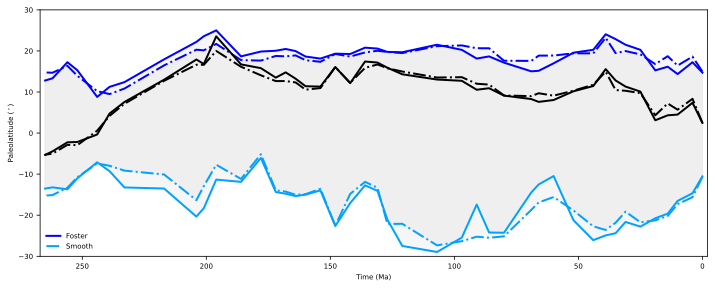

In [12]:
f, ax = plt.subplots(figsize=(10, 4))

ax.set(ylabel='Paleolatitude ($^\circ$)',
       xlabel='Time (Ma)')
plt.plot(time, centroid_foster['centroidN'], color = 'b', lw='2', ls='-',zorder=3,label='Foster')
plt.plot(time, centroid_foster['centroidS'], color = '#00A2FF', lw='2', ls='-',zorder=3)

plt.plot(time, centroid_smooth['centroidN'], color = 'b', lw='2', ls='-.',zorder=3)
plt.plot(time, centroid_smooth['centroidS'], color = '#00A2FF', lw='2', ls='-.',zorder=3,label='Smooth')

plt.plot(time, centroid_foster['centroid'], color = 'k', lw='2', ls='-',zorder=3)
plt.plot(time, centroid_smooth['centroid'], color = 'k', lw='2', ls='-.',zorder=3)


plt.fill_between(time, centroid_foster['centroidS'], centroid_foster['centroidN'], 
                 color='lightgrey',alpha=0.2)
plt.fill_between(time, centroid_smooth['centroidS'], centroid_smooth['centroidN'], 
                 color='lightgrey',alpha=0.2)

plt.ylim(-30, 30)
plt.xlim(-2, 267)
ax.invert_xaxis()
plt.legend(loc="lower left",frameon=False)
f.tight_layout()
plt.savefig('figs/centroid.png', bbox_inches='tight', transparent=True, dpi=500)
plt.show()
plt.close()